# Melatih Model YOLOv8 untuk Deteksi Komponen Elektronik

Notebook ini akan memandu Anda melalui proses:
1. Menyiapkan dataset dari folder gambar
2. Melatih model YOLOv8 untuk deteksi komponen elektronik
3. Mengevaluasi hasil pelatihan
4. Menyimpan model untuk digunakan di aplikasi SOMEBODY

In [ ]:
## 1. Instalasi Dependencies

In [2]:
%pip install ultralytics>=8.0.196 matplotlib>=3.7.2 opencv-python>=4.8.0 tqdm>=4.66.1 pillow>=10.0.0

Note: you may need to restart the kernel to use updated packages.


In [33]:
import os
import glob
import cv2
import numpy as np
import shutil
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
# Abaikan peringatan yang mungkin muncul di Python 3.12
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Import tqdm dengan handling untuk compatibility
try:
    from tqdm.notebook import tqdm
except ImportError:
    from tqdm import tqdm

# Import YOLO dengan error handling
try:
    from ultralytics import YOLO
except ImportError:
    raise ImportError("Ultralytics tidak dapat diimpor. Pastikan instalasi berhasil.")

# Set seed untuk reproduksibilitas
np.random.seed(42)

## 2. Persiapan Dataset

### 2.1 Tentukan Path

In [34]:
# Lokasi folder dataset sumber (berisi subfolder komponen)
SOURCE_DIR = "./foto_komponen"

# Lokasi folder output untuk dataset YOLO
OUTPUT_DIR = "./dataset_elektronik"

# Rasio pembagian train/val
SPLIT_RATIO = 0.8

### 2.2 Eksplorasi Dataset

In [39]:
# Buat direktori sumber jika belum ada (untuk testing)
os.makedirs(SOURCE_DIR, exist_ok=True)

# Cek subfolder yang ada (kelas-kelas komponen)
class_dirs = [d for d in os.listdir(SOURCE_DIR) if os.path.isdir(os.path.join(SOURCE_DIR, d))]
class_dirs.sort()  # Pastikan urutan selalu sama

print(f"Kelas yang ditemukan: {class_dirs}")

# Jika tidak ada kelas yang ditemukan, beri peringatan
if not class_dirs:
    print("PERINGATAN: Tidak ada subfolder kelas yang ditemukan di", SOURCE_DIR)
    print("Pastikan Anda telah membuat subfolder untuk setiap jenis komponen elektronik")
else:
    # Hitung jumlah gambar per kelas
    for class_name in class_dirs:
        class_dir = os.path.join(SOURCE_DIR, class_name)
        image_files = []
        for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']:
            image_files.extend(glob.glob(os.path.join(class_dir, ext)))
        print(f"  - {class_name}: {len(image_files)} gambar")

Kelas yang ditemukan: ['esp32']
  - esp32: 76 gambar


### 2.3 Visualisasi Beberapa Gambar

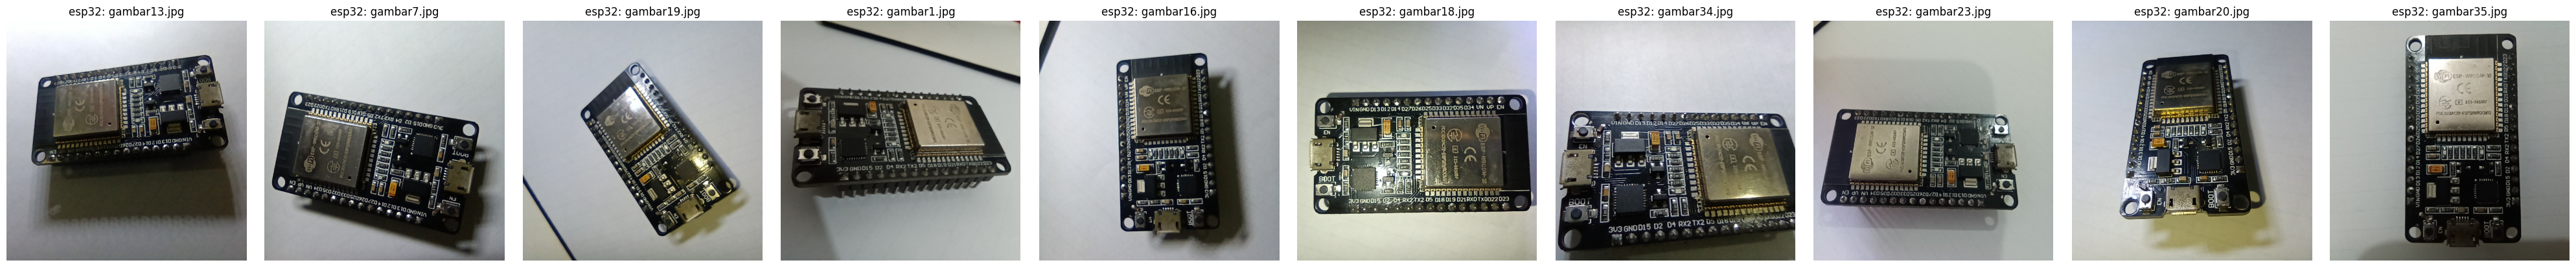

In [40]:
# Tampilkan beberapa sampel gambar dari setiap kelas
def visualize_samples():
    if not class_dirs:
        print("Tidak ada kelas untuk divisualisasikan.")
        return
        
    rows = len(class_dirs)
    # Menghitung kolom dengan handling jika class_dirs kosong
    try:
        cols = min(10, max([len(glob.glob(os.path.join(SOURCE_DIR, cls, "*.jpg")) + 
                         glob.glob(os.path.join(SOURCE_DIR, cls, "*.png")) +
                         glob.glob(os.path.join(SOURCE_DIR, cls, "*.jpeg"))) 
                       for cls in class_dirs] or [0]))
    except ValueError:
        print("Tidak ada gambar untuk divisualisasikan.")
        return
        
    if cols == 0:
        print("Tidak ada gambar ditemukan di folder kelas.")
        return

    # Buat grid plot
    fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
    
    # Handle kasus ketika hanya ada satu baris atau satu kolom
    if rows == 1 and cols == 1:
        axes = np.array([[axes]])
    elif rows == 1:
        axes = np.array([axes])
    elif cols == 1:
        axes = np.array([[ax] for ax in axes])

    for i, class_name in enumerate(class_dirs):
        class_dir = os.path.join(SOURCE_DIR, class_name)
        image_files = []
        for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']:
            image_files.extend(glob.glob(os.path.join(class_dir, ext)))
        
        if not image_files:
            for j in range(cols):
                axes[i, j].axis('off')
                axes[i, j].text(0.5, 0.5, f"No images in {class_name}", 
                               ha='center', va='center')
            continue
            
        # Ambil sampel random
        samples = np.random.choice(image_files, min(cols, len(image_files)), replace=False)
        
        for j, sample in enumerate(samples):
            try:
                img = cv2.imread(sample)
                if img is None:
                    axes[i, j].text(0.5, 0.5, f"Unable to read image", 
                                   ha='center', va='center')
                    axes[i, j].axis('off')
                    continue
                    
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                axes[i, j].imshow(img)
                axes[i, j].set_title(f"{class_name}: {os.path.basename(sample)}")
                axes[i, j].axis('off')
            except Exception as e:
                print(f"Error visualizing {sample}: {str(e)}")
                axes[i, j].text(0.5, 0.5, f"Error loading image", 
                               ha='center', va='center')
                axes[i, j].axis('off')
                
        # Fill remaining axes in this row with empty plots
        for j in range(len(samples), cols):
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

# Execute the visualization function
visualize_samples()

### 2.4 Fungsi Konversi Dataset ke Format YOLO

In [41]:
def process_image(img_path, images_dir, labels_dir, class_id):
    """Memproses gambar dan membuat anotasi YOLO dengan handling untuk Python 3.12"""
    try:
        # Baca gambar untuk mendapatkan dimensi
        img = cv2.imread(img_path)
        if img is None:
            print(f"Tidak bisa membaca gambar: {img_path}")
            return
            
        height, width = img.shape[:2]
        
        # Buat nama file baru
        img_filename = Path(img_path).name
        base_name = Path(img_filename).stem
        
        # Salin gambar ke folder tujuan
        dst_img_path = os.path.join(images_dir, img_filename)
        shutil.copy2(img_path, dst_img_path)
        
        # Metode semi-otomatis - Deteksi objek utama dengan error handling
        try:
            # Konversi ke grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # Blur untuk mengurangi noise
            blur = cv2.GaussianBlur(gray, (5, 5), 0)
            # Thresholding
            _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            
            # Temukan kontur - handling untuk perubahan API di OpenCV versi baru
            contours_result = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            # Ekstrak kontur berdasarkan versi OpenCV
            if len(contours_result) == 3:  # OpenCV 3.x
                _, contours, _ = contours_result
            else:  # OpenCV 4.x (termasuk yang digunakan di Python 3.12)
                contours, _ = contours_result
            
            # Jika ada kontur, gunakan yang terbesar
            if contours and len(contours) > 0:
                # Ambil kontur terbesar
                c = max(contours, key=cv2.contourArea)
                x, y, w, h = cv2.boundingRect(c)
                
                # Konversi ke format YOLO (x_center, y_center, width, height)
                x_center = (x + w/2) / width
                y_center = (y + h/2) / height
                bbox_width = w / width
                bbox_height = h / height
                
                # Validasi bbox - jika terlalu kecil, gunakan default
                if bbox_width < 0.1 or bbox_height < 0.1:
                    x_center, y_center = 0.5, 0.5
                    bbox_width, bbox_height = 0.8, 0.8
            else:
                # Default - objek di tengah
                x_center, y_center = 0.5, 0.5
                bbox_width, bbox_height = 0.8, 0.8
        except Exception as e:
            print(f"Error saat deteksi objek pada {img_path}: {str(e)}")
            # Default fallback jika terjadi error
            x_center, y_center = 0.5, 0.5
            bbox_width, bbox_height = 0.8, 0.8
        
        # Tulis file label YOLO (format: class_id center_x center_y width height)
        label_path = os.path.join(labels_dir, f"{base_name}.txt")
        with open(label_path, 'w') as f:
            f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}\n")
            
    except Exception as e:
        print(f"Error memproses gambar {img_path}: {str(e)}")

In [43]:
def create_yolo_dataset(source_dir, output_dir, split_ratio=0.8):
    """Membuat dataset dalam format YOLO dari folder gambar"""
    # Buat struktur folder YOLO
    os.makedirs(output_dir, exist_ok=True)
    
    # Buat subfolder
    images_train_dir = os.path.join(output_dir, "images", "train")
    images_val_dir = os.path.join(output_dir, "images", "val")
    labels_train_dir = os.path.join(output_dir, "labels", "train")
    labels_val_dir = os.path.join(output_dir, "labels", "val")
    
    os.makedirs(images_train_dir, exist_ok=True)
    os.makedirs(images_val_dir, exist_ok=True)
    os.makedirs(labels_train_dir, exist_ok=True)
    os.makedirs(labels_val_dir, exist_ok=True)
    
    # Buat daftar kelas dari subfolder
    class_dirs = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]
    if not class_dirs:
        raise ValueError(f"Tidak ada subfolder kelas yang ditemukan di {source_dir}")
        
    class_dirs.sort()  # Pastikan urutan sama setiap kali
    
    print(f"Kelas yang ditemukan: {class_dirs}")
    
    # Buat file data.yaml
    with open(os.path.join(output_dir, "data.yaml"), 'w') as f:
        f.write(f"path: {output_dir}\n")
        f.write(f"train: images/train\n")
        f.write(f"val: images/val\n\n")
        f.write(f"nc: {len(class_dirs)}\n")
        f.write(f"names: {class_dirs}\n")
    
    # Proses setiap kelas
    for class_id, class_name in enumerate(class_dirs):
        class_dir = os.path.join(source_dir, class_name)
        print(f"Memproses kelas {class_name} (ID: {class_id})")
        
        # Dapatkan semua gambar
        image_files = []
        for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']:
            image_files.extend(glob.glob(os.path.join(class_dir, ext)))
        
        if not image_files:
            print(f"  - PERINGATAN: Tidak ada gambar ditemukan untuk kelas {class_name}")
            continue
            
        print(f"  - Menemukan {len(image_files)} gambar")
        
        # Acak dan bagi menjadi train/val
        np.random.shuffle(image_files)
        n_train = max(1, int(len(image_files) * split_ratio))  # Minimal 1 gambar untuk train
        
        train_files = image_files[:n_train]
        val_files = image_files[n_train:]
        
        print(f"  - Train: {len(train_files)}, Val: {len(val_files)}")
        
        # Proses gambar train
        for img_path in tqdm(train_files, desc=f"Train {class_name}"):
            process_image(img_path, images_train_dir, labels_train_dir, class_id)
        
        # Proses gambar val
        for img_path in tqdm(val_files, desc=f"Val {class_name}"):
            process_image(img_path, images_val_dir, labels_val_dir, class_id)
    
    # Cek hasil
    train_count = len(os.listdir(images_train_dir))
    val_count = len(os.listdir(images_val_dir))
    
    if train_count == 0:
        print("\nPERINGATAN: Tidak ada gambar training yang dihasilkan!")
    if val_count == 0:
        print("\nPERINGATAN: Tidak ada gambar validasi yang dihasilkan!")
        
    print(f"\nDataset komponen elektronik berhasil dibuat di {output_dir}")
    print(f"Total gambar train: {train_count}")
    print(f"Total gambar val: {val_count}")
    
    return os.path.join(output_dir, "data.yaml")

### 2.5 Buat Dataset YOLO

In [44]:
try:
    # Buat dataset YOLO dari folder gambar
    data_yaml_path = create_yolo_dataset(SOURCE_DIR, OUTPUT_DIR, SPLIT_RATIO)
except Exception as e:
    print(f"Error saat membuat dataset YOLO: {str(e)}")
    # Set default path untuk memungkinkan running sel berikutnya
    data_yaml_path = os.path.join(OUTPUT_DIR, "data.yaml")

Exception ignored in: <function tqdm.__del__ at 0x00000215075D20C0>
Traceback (most recent call last):
  File "c:\Users\Pongo\Documents\KULIAH\SIKIRIKIRPSUSI\SOMEBODY\.venv\Lib\site-packages\tqdm\std.py", line 1149, in __del__
    self.close()
  File "c:\Users\Pongo\Documents\KULIAH\SIKIRIKIRPSUSI\SOMEBODY\.venv\Lib\site-packages\tqdm\notebook.py", line 278, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


Kelas yang ditemukan: ['esp32']
Memproses kelas esp32 (ID: 0)
  - Menemukan 76 gambar
  - Train: 60, Val: 16
Error saat membuat dataset YOLO: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


### 2.6 Visualisasi Anotasi

In [24]:
# Fungsi untuk menampilkan gambar dengan bounding box
def display_image_with_annotation(image_path, label_path, class_names):
    try:
        # Baca gambar
        img = cv2.imread(image_path)
        if img is None:
            print(f"Tidak bisa membaca gambar: {image_path}")
            return
            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        height, width = img.shape[:2]
        
        # Baca label
        if not os.path.exists(label_path):
            print(f"File label tidak ditemukan: {label_path}")
            return
            
        with open(label_path, 'r') as f:
            lines = f.readlines()
        
        # Plot gambar
        plt.figure(figsize=(10, 10))
        plt.imshow(img)
        
        # Plot bounding box untuk setiap objek
        for line in lines:
            values = line.strip().split()
            if len(values) < 5:
                print(f"Format label tidak valid: {line}")
                continue
                
            try:
                class_id = int(values[0])
                x_center = float(values[1]) * width
                y_center = float(values[2]) * height
                box_width = float(values[3]) * width
                box_height = float(values[4]) * height
                
                # Hitung koordinat untuk plotting
                x1 = int(x_center - box_width/2)
                y1 = int(y_center - box_height/2)
                x2 = int(x_center + box_width/2)
                y2 = int(y_center + box_height/2)
                
                # Plot bounding box
                rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=2)
                plt.gca().add_patch(rect)
                
                # Plot label
                class_name = class_names[class_id] if class_id < len(class_names) else f"Class {class_id}"
                plt.text(x1, y1-5, class_name, color='white', fontweight='bold', 
                         bbox=dict(facecolor='red', alpha=0.8))
            except (ValueError, IndexError) as e:
                print(f"Error parsing label line: {line}, error: {str(e)}")
        
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error displaying image with annotation: {str(e)}")

In [45]:
# Tampilkan beberapa sampel gambar training dengan anotasi
def visualize_annotations():
    image_dir = os.path.join(OUTPUT_DIR, "images", "train")
    label_dir = os.path.join(OUTPUT_DIR, "labels", "train")
    
    if not os.path.exists(image_dir) or not os.path.exists(label_dir):
        print("Direktori gambar atau label tidak ditemukan!")
        return
    
    # Ambil semua format gambar
    image_files = []
    for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']:
        image_files.extend(glob.glob(os.path.join(image_dir, ext)))
    
    if not image_files:
        print("Tidak ada gambar training yang ditemukan!")
        return
        
    # Ambil 5 gambar random untuk ditampilkan
    try:
        samples = np.random.choice(image_files, min(5, len(image_files)), replace=False)
        
        for sample in samples:
            base_name = os.path.basename(sample).split('.')[0]
            label_path = os.path.join(label_dir, f"{base_name}.txt")
            
            if os.path.exists(label_path):
                display_image_with_annotation(sample, label_path, class_dirs)
            else:
                print(f"Label tidak ditemukan untuk {os.path.basename(sample)}")
    except Exception as e:
        print(f"Error saat visualisasi anotasi: {str(e)}")

# Execute the visualization function
visualize_annotations()

Tidak ada gambar training yang ditemukan!


## 3. Pelatihan Model YOLOv8

### 3.1 Konfigurasi Pelatihan

In [26]:
# Tentukan model YOLO yang akan digunakan
MODEL_SIZE = "n"  # Pilihan: n, s, m, l, x (dari kecil ke besar)
PRETRAINED_MODEL = f"yolov8{MODEL_SIZE}.pt"

# Parameter pelatihan dengan nilai lebih konservatif untuk stabilitas
EPOCHS = 50
BATCH_SIZE = 16  # Sesuaikan jika memori GPU tidak cukup
IMG_SIZE = 640

# Folder output untuk model terlatih
MODEL_DIR = "./models/yolo_electronics"
os.makedirs(MODEL_DIR, exist_ok=True)

### 3.2 Pelatihan Model

In [27]:
def train_model():
    try:
        # Validasi data_yaml_path
        if not os.path.exists(data_yaml_path):
            print(f"File konfigurasi dataset tidak ditemukan: {data_yaml_path}")
            print("Pastikan dataset telah dibuat dengan benar.")
            return None
            
        # Load model YOLO yang sudah dilatih sebelumnya
        try:
            model = YOLO(PRETRAINED_MODEL)
        except Exception as e:
            print(f"Error saat loading model pretrained: {str(e)}")
            print("Mencoba download ulang model...")
            # Alternatif jika ada masalah dengan model lokal
            model = YOLO(f"https://github.com/ultralytics/assets/releases/download/v0.0.0/yolov8{MODEL_SIZE}.pt")

        print(f"Memulai pelatihan model dengan {EPOCHS} epochs...")
        # Latih model dengan dataset yang sudah disiapkan
        results = model.train(
            data=data_yaml_path,
            epochs=EPOCHS,
            batch=BATCH_SIZE,
            imgsz=IMG_SIZE,
            project=MODEL_DIR,
            name="electronics_detector",
            verbose=True,
            exist_ok=True  # Izinkan overwrite folder hasil
        )
        
        print("Pelatihan selesai!")
        return model
        
    except Exception as e:
        print(f"Error selama pelatihan model: {str(e)}")
        return None

# Latih model
model = train_model()

Error saat loading model pretrained: Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL ultralytics.nn.tasks.DetectionModel was not an allowed global by default. Please use `torch.serialization.add_safe_globals([DetectionModel])` or the `torch.serialization.safe_globals([DetectionModel])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about t

## 4. Evaluasi Model

### 4.1 Evaluasi pada Data Validasi

In [ ]:
def evaluate_model():
    if model is None:
        print("Model belum dilatih, tidak dapat melakukan evaluasi!")
        return None
        
    try:
        # Jalankan evaluasi pada dataset validasi
        print("Mengevaluasi model pada data validasi...")
        val_results = model.val()
        return val_results
    except Exception as e:
        print(f"Error saat evaluasi model: {str(e)}")
        return None

# Evaluasi model
val_results = evaluate_model()

In [ ]:
# Tampilkan metrik evaluasi
if val_results is not None:
    try:
        print(f"mAP50-95: {val_results.box.map}")
        print(f"mAP50: {val_results.box.map50}")
        print(f"mAP75: {val_results.box.map75}")
        print(f"Precision: {val_results.box.mp}")
        print(f"Recall: {val_results.box.mr}")
    except Exception as e:
        print(f"Error menampilkan metrik evaluasi: {str(e)}")
else:
    print("Evaluasi tidak berhasil dilakukan.")

### 4.2 Visualisasi Kurva Pelatihan

In [ ]:
# Tampilkan plot pelatihan jika tersedia
def display_training_curves():
    model_log_dir = os.path.join(MODEL_DIR, "electronics_detector")
    results_plot = os.path.join(model_log_dir, "results.png")
    
    if os.path.exists(results_plot):
        try:
            img = plt.imread(results_plot)
            plt.figure(figsize=(15, 10))
            plt.imshow(img)
            plt.axis('off')
            plt.show()
        except Exception as e:
            print(f"Error menampilkan kurva pelatihan: {str(e)}")
    else:
        print(f"Plot hasil pelatihan tidak ditemukan di {results_plot}")
        print("Pastikan pelatihan telah selesai dengan sukses.")

# Visualisasi kurva pelatihan
display_training_curves()

## 5. Pengujian Model pada Gambar

In [ ]:
def load_best_model():
    # Path ke model terbaik dari pelatihan
    best_model_path = os.path.join(MODEL_DIR, "electronics_detector", "weights", "best.pt")
    
    if not os.path.exists(best_model_path):
        print(f"Model terbaik tidak ditemukan di {best_model_path}")
        print("Mencoba menggunakan model terakhir...")
        
        # Coba gunakan model terakhir jika best tidak ada
        last_model_path = os.path.join(MODEL_DIR, "electronics_detector", "weights", "last.pt")
        if not os.path.exists(last_model_path):
            print("Model terakhir juga tidak ditemukan. Gunakan model yang dilatih saat ini jika tersedia.")
            return model  # Gunakan model yang dilatih sebelumnya
            
        best_model_path = last_model_path
    
    try:
        # Load model terbaik
        print(f"Loading model dari {best_model_path}")
        trained_model = YOLO(best_model_path)
        return trained_model
    except Exception as e:
        print(f"Error saat loading model terbaik: {str(e)}")
        return None

# Load model terbaik
trained_model = load_best_model()

In [ ]:
# Uji pada beberapa gambar validasi
def test_on_validation_images():
    if trained_model is None:
        print("Model tidak tersedia untuk pengujian!")
        return
        
    val_img_dir = os.path.join(OUTPUT_DIR, "images", "val")
    
    if not os.path.exists(val_img_dir):
        print(f"Direktori gambar validasi tidak ditemukan: {val_img_dir}")
        return
        
    # Ambil semua format gambar
    val_image_files = []
    for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']:
        val_image_files.extend(glob.glob(os.path.join(val_img_dir, ext)))

    if not val_image_files:
        print("Tidak ada gambar validasi yang ditemukan!")
        return
        
    try:
        # Pilih gambar untuk pengujian
        test_images = np.random.choice(val_image_files, min(5, len(val_image_files)), replace=False)
        
        for img_path in test_images:
            # Prediksi dengan model
            try:
                results = trained_model(img_path)
                
                # Plot hasil
                fig = results[0].plot()
                plt.figure(figsize=(12, 12))
                plt.imshow(fig)
                plt.axis('off')
                plt.title(f"Deteksi pada {os.path.basename(img_path)}")
                plt.show()
            except Exception as e:
                print(f"Error saat prediksi {os.path.basename(img_path)}: {str(e)}")
    except Exception as e:
        print(f"Error saat pengujian gambar validasi: {str(e)}")

# Uji model pada gambar validasi
test_on_validation_images()

## 6. Ekspor Model untuk SOMEBODY

In [ ]:
def export_model_for_somebody():
    # Path ke model terbaik
    best_model_path = os.path.join(MODEL_DIR, "electronics_detector", "weights", "best.pt")
    
    if not os.path.exists(best_model_path):
        print(f"Model terbaik tidak ditemukan di {best_model_path}")
        print("Tidak dapat melakukan ekspor model.")
        return
        
    try:
        # Buat direktori untuk model di aplikasi SOMEBODY
        somebody_model_dir = "./data/models/yolo/custom/electronic_components/weights"
        os.makedirs(somebody_model_dir, exist_ok=True)

        # Salin model terbaik
        somebody_model_path = os.path.join(somebody_model_dir, "best.pt")
        shutil.copy2(best_model_path, somebody_model_path)

        print(f"Model berhasil disalin ke {somebody_model_path}")
        print("\nModel ini siap digunakan oleh aplikasi SOMEBODY!")
        print("Untuk menggunakannya, pastikan path model diatur di brain.py atau diatur melalui API.")
    except Exception as e:
        print(f"Error saat mengekspor model: {str(e)}")

# Ekspor model
export_model_for_somebody()

## 7. Pengujian Realtime dengan Kamera

Opsional: Gunakan untuk menguji model dengan kamera secara langsung

In [ ]:
def test_with_camera(model_path=None, cam_id=0, confidence=0.25):
    """Uji model dengan kamera realtime"""
    if model_path is None:
        # Gunakan model terbaik jika tidak ada path yang diberikan
        model_path = os.path.join(MODEL_DIR, "electronics_detector", "weights", "best.pt")
        if not os.path.exists(model_path):
            print(f"Model tidak ditemukan di {model_path}")
            return
    
    try:
        # Load model
        model = YOLO(model_path)
        
        # Buka kamera
        cap = cv2.VideoCapture(cam_id)
        if not cap.isOpened():
            print(f"Tidak dapat membuka kamera (ID: {cam_id})")
            return
            
        print("Kamera berhasil dibuka. Tekan 'q' untuk keluar.")
        
        while True:
            # Baca frame
            ret, frame = cap.read()
            if not ret:
                print("Tidak dapat membaca frame dari kamera.")
                break
                
            # Prediksi dengan model
            try:
                results = model(frame, conf=confidence)[0]
                
                # Visualisasi hasil
                annotated_frame = results.plot()
                
                # Tampilkan
                cv2.imshow('YOLO Electronics Detector', annotated_frame)
                
                # Keluar dengan tombol 'q'
                if cv2.waitKey(1) == ord('q'):
                    break
            except Exception as e:
                print(f"Error saat prediksi: {str(e)}")
                # Tampilkan frame tanpa anotasi jika terjadi error
                cv2.imshow('YOLO Electronics Detector', frame)
                if cv2.waitKey(1) == ord('q'):
                    break
    except Exception as e:
        print(f"Error saat menjalankan deteksi kamera: {str(e)}")
    finally:
        # Bersihkan
        try:
            cap.release()
            cv2.destroyAllWindows()
        except:
            pass

# Uncomment untuk menggunakan kamera
# test_with_camera()